# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [45]:
import pandas as pd
from stable_baselines3.common.logger import configure

import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from Envs.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

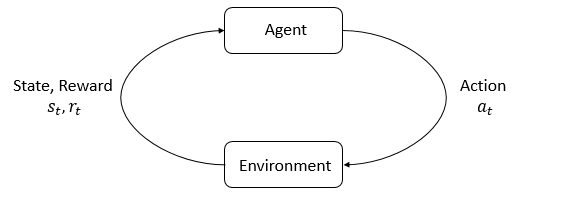

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [46]:
train = pd.read_csv('train_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

In [47]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754724,746015200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,2.754724,2.754724,39.189999,0.000000
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422924,6547900.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,43.422924,43.422924,39.189999,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256270,10955700.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,15.256270,15.256270,39.189999,0.000000
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941090,7010200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,33.941090,33.941090,39.189999,0.000000
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254068,7117200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,31.254068,31.254068,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,282.806396,2932900.0,1.0,-0.019138,298.676589,266.566270,52.413041,-25.974551,1.846804,283.046084,276.148069,30.430000,12.918778
2892,2020-06-30,V,191.490005,193.750000,190.160004,189.235092,9040100.0,1.0,1.040529,197.185265,183.584111,53.021037,-51.626992,2.013358,189.976997,180.246881,30.430000,12.918778
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,46.551456,17414800.0,1.0,-0.403920,49.824212,45.029134,48.097028,-51.313221,8.508886,47.138594,47.556786,30.430000,12.918778


Goal for generated data: one more column for sentiment for each day --> Merge on "tic" and "date"

In [48]:
jason = [{
    "date" : "2012-06-27",
    "symbol" : "AAPL",
    "stocktwitsPosts" : 13,
    "twitterPosts" : 163,
    "stocktwitsComments" : 9,
    "twitterComments" : 7769,
    "stocktwitsLikes" : 16,
    "twitterLikes" : 40957,
    "stocktwitsImpressions" : 15141,
    "twitterImpressions" : 1576854,
    "stocktwitsSentiment" : 0.5411,
    "twitterSentiment" : 0.5888
  }, {
    "date" : "2012-06-28",
    "symbol" : "AAPL",
    "stocktwitsPosts" : 19,
    "twitterPosts" : 76,
    "stocktwitsComments" : 8,
    "twitterComments" : 1206,
    "stocktwitsLikes" : 47,
    "twitterLikes" : 8909,
    "stocktwitsImpressions" : 51534,
    "twitterImpressions" : 327871,
    "stocktwitsSentiment" : 0.5518,
    "twitterSentiment" : 0.5299
  },
    {
    "date" : "2012-06-29",
    "symbol" : "AAPL",
    "stocktwitsPosts" : 13,
    "twitterPosts" : 163,
    "stocktwitsComments" : 9,
    "twitterComments" : 7769,
    "stocktwitsLikes" : 16,
    "twitterLikes" : 40957,
    "stocktwitsImpressions" : 15141,
    "twitterImpressions" : 1576854,
    "stocktwitsSentiment" : 0.5411,
    "twitterSentiment" : 0.5888
  }, {
    "date" : "2012-06-30",
    "symbol" : "AAPL",
    "stocktwitsPosts" : 19,
    "twitterPosts" : 76,
    "stocktwitsComments" : 8,
    "twitterComments" : 1206,
    "stocktwitsLikes" : 47,
    "twitterLikes" : 8909,
    "stocktwitsImpressions" : 51534,
    "twitterImpressions" : 327871,
    "stocktwitsSentiment" : 0.5518,
    "twitterSentiment" : 0.5299
  }]

In [49]:
df = pd.DataFrame(jason)
df.rename(columns={'symbol':'tic'}, inplace=True)
df

,date,tic,stocktwitsPosts,twitterPosts,stocktwitsComments,twitterComments,stocktwitsLikes,twitterLikes,stocktwitsImpressions,twitterImpressions,stocktwitsSentiment,twitterSentiment
0,2012-06-27,AAPL,13,163,9,7769,16,40957,15141,1576854,0.5411,0.5888
1,2012-06-28,AAPL,19,76,8,1206,47,8909,51534,327871,0.5518,0.5299
2,2012-06-29,AAPL,13,163,9,7769,16,40957,15141,1576854,0.5411,0.5888
3,2012-06-30,AAPL,19,76,8,1206,47,8909,51534,327871,0.5518,0.5299


In [50]:
sentiment = df[["date", "tic", "twitterSentiment"]]

In [51]:
sentiment

,date,tic,twitterSentiment
0,2012-06-27,AAPL,0.5888
1,2012-06-28,AAPL,0.5299
2,2012-06-29,AAPL,0.5888
3,2012-06-30,AAPL,0.5299


In [52]:
# Exclude specific columns
exclude_columns = ['date', 'tic']
SENTIMENT = [col for col in sentiment if col not in exclude_columns]
SENTIMENT

['twitterSentiment']

In [53]:
print (train["date"].min())
print (train["date"].max())


2009-01-02
2020-06-30


In [67]:
def data_generator(ticker, df):
    num_samples = len(pd.date_range(df["date"].min(), df["date"].max()))
    sampled_sentiment = np.random.random_sample((num_samples,))
    sentiment = pd.DataFrame({'date':pd.date_range(df["date"].min(), df["date"].max()),
                   'tic':ticker, 
                   'twitterSentiment':sampled_sentiment
                   })
    return sentiment

    
    

In [68]:
tickers = train["tic"].unique()
#tickers = tickers[0:2]

In [69]:
tickers

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
       'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype=object)

In [70]:
df = pd.DataFrame()
for ticker in tickers:
    sentiment = data_generator(ticker, train)
    df = pd.concat([df, sentiment], ignore_index=True)

df

,date,tic,twitterSentiment
0,2009-01-02,AAPL,0.804671
1,2009-01-03,AAPL,0.957454
2,2009-01-04,AAPL,0.725503
3,2009-01-05,AAPL,0.288907
4,2009-01-06,AAPL,0.376963
...,...,...,...
121737,2020-06-26,WMT,0.951949
121738,2020-06-27,WMT,0.406729
121739,2020-06-28,WMT,0.088155
121740,2020-06-29,WMT,0.102740


In [71]:
#sentiment = data_generator("AAPL", train)

In [72]:
train['date'] = train['date'].astype('datetime64[ns]')

In [73]:
idx = train.index

In [74]:
train = pd.merge(train, df,  how='left', left_on=['date','tic'], right_on = ['date','tic'])
#train = train.dropna()
train.index = idx

In [75]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,sentiment,twitterSentiment
,,,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754724,746015200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,2.754724,2.754724,39.189999,0.000000,0.287847,0.804671
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422924,6547900.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,43.422924,43.422924,39.189999,0.000000,0.986021,0.445140
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256270,10955700.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,15.256270,15.256270,39.189999,0.000000,0.726493,0.765932
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941090,7010200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,33.941090,33.941090,39.189999,0.000000,0.945528,0.168080
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254068,7117200.0,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,31.254068,31.254068,39.189999,0.000000,0.137686,0.288533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,282.806396,2932900.0,1.0,-0.019138,298.676589,266.566270,52.413041,-25.974551,1.846804,283.046084,276.148069,30.430000,12.918778,0.766910,0.615003
2892,2020-06-30,V,191.490005,193.750000,190.160004,189.235092,9040100.0,1.0,1.040529,197.185265,183.584111,53.021037,-51.626992,2.013358,189.976997,180.246881,30.430000,12.918778,0.376198,0.948480
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,46.551456,17414800.0,1.0,-0.403920,49.824212,45.029134,48.097028,-51.313221,8.508886,47.138594,47.556786,30.430000,12.918778,0.435151,0.146518


## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [76]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension +  len(SENTIMENT)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 320


In [77]:
SENTIMENT

['twitterSentiment']

In [78]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [79]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "sentiment_list" : SENTIMENT,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for training

In [80]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [81]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [82]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [83]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 99         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -42.1      |
|    reward             | 0.26583004 |
|    std                | 1          |
|    value_loss         | 1.4        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 102        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.0365    |
|    learning_rate      |

KeyboardInterrupt: 

In [139]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [9]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [11]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50) if if_using_ddpg else None

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [12]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [13]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 45         |
|    iterations      | 1          |
|    time_elapsed    | 44         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.31128678 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 2           |
|    time_elapsed         | 90          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015403882 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0119     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.48        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0307     |
|   

-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 12          |
|    time_elapsed         | 595         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023128178 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | -0.0209     |
|    learning_rate        | 0.00025     |
|    loss                 | 20.7        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0111     |
|    reward               | -0.17601006 |
|    std                  | 1.02        |
|    value_loss           | 52.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 13    

-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 22          |
|    time_elapsed         | 1084        |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.023760147 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.1       |
|    explained_variance   | 0.0146      |
|    learning_rate        | 0.00025     |
|    loss                 | 23          |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.007      |
|    reward               | 2.0401194   |
|    std                  | 1.04        |
|    value_loss           | 51.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 23    

day: 2892, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 3243555.19
total_reward: 2243555.19
total_cost: 285552.40
total_trades: 75997
Sharpe: 0.630
-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 32          |
|    time_elapsed         | 1580        |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.016851306 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.4       |
|    explained_variance   | 0.0239      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.8        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00735    |
|    reward               | 0.46168545  |
|    std                  | 1.04        |
|    value_loss           | 38.7        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 42          |
|    time_elapsed         | 1969        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.02106736  |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0226      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00763    |
|    reward               | -0.07551384 |
|    std                  | 1.06        |
|    value_loss           | 78.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 44         |
|    iterations           | 43       

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 52          |
|    time_elapsed         | 2272        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.008009402 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.00851     |
|    learning_rate        | 0.00025     |
|    loss                 | 110         |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0108     |
|    reward               | -8.162935   |
|    std                  | 1.08        |
|    value_loss           | 358         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 62          |
|    time_elapsed         | 2577        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.027008304 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | 0.0505      |
|    learning_rate        | 0.00025     |
|    loss                 | 43.6        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00935    |
|    reward               | 6.6512985   |
|    std                  | 1.09        |
|    value_loss           | 66.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 63    

-----------------------------------------
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 72          |
|    time_elapsed         | 2883        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.015441446 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.3        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0051     |
|    reward               | -9.417746   |
|    std                  | 1.11        |
|    value_loss           | 69.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 73    

-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 82          |
|    time_elapsed         | 3180        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.015684314 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0692      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.4        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0122     |
|    reward               | -0.6564304  |
|    std                  | 1.12        |
|    value_loss           | 157         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 83    

-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 92          |
|    time_elapsed         | 3463        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.031162115 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.8       |
|    explained_variance   | 0.0296      |
|    learning_rate        | 0.00025     |
|    loss                 | 62.7        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00606    |
|    reward               | -2.0798807  |
|    std                  | 1.14        |
|    value_loss           | 68.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 54         |
|    iterations           | 93       

In [14]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [ ]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".